# FOD KAGGLE

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

In [2]:
ROOT_DATA = 'data'
aisles_df = pd.read_csv(os.path.join(ROOT_DATA, 'aisles.csv'))
departments_df = pd.read_csv(os.path.join(ROOT_DATA, 'departments.csv'))
products_df = pd.read_csv(os.path.join(ROOT_DATA, 'products.csv'))
orders_df = pd.read_csv(os.path.join(ROOT_DATA, 'orders.csv'))
order_products_train_df = pd.read_csv(os.path.join(ROOT_DATA, 'order_products__train.csv'))
order_products_prior_df = pd.read_csv(os.path.join(ROOT_DATA, 'order_products__prior.csv'))

## Data Viz

### Utils

In [3]:
def get_order_df(df, order_id):
    return df[df['order_id'] == order_id]

def get_order_user_id(orders, order_id):
    return orders[orders['order_id'] == order_id].iloc[0]['user_id']


### Visualizing dataframes

In [6]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [13]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [14]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [15]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [16]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [17]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Feature engineering

In [18]:
def get_numbers_of_products_features_df(orders_df, order_products_prior_df):
    # Get number of products by order
    order_nb_of_products = order_products_prior_df.groupby('order_id')['product_id'].count()
    order_nb_of_products_df = order_nb_of_products.to_frame()
    order_nb_of_products_df = order_nb_of_products_df.rename(columns = {'product_id':'nb_of_products'})

    # Get user_id of each order
    order_products_by_user = order_nb_of_products_df.join(orders_df)
    order_products_by_user = order_products_by_user[order_products_by_user.eval_set == 'prior']

    # Compute features
    mean_products_by_id = order_products_by_user.groupby('user_id')['nb_of_products'].mean()
    sum_products_by_id = order_products_by_user.groupby('user_id')['nb_of_products'].sum()
    std_products_by_id = order_products_by_user.groupby('user_id')['nb_of_products'].std()

    # Rename features
    mean_products_by_id_df = mean_products_by_id.to_frame(name="mean_nb_products_by_order")
    sum_products_by_id_df = sum_products_by_id.to_frame(name="sum_nb_products_by_order")
    std_products_by_id_df = std_products_by_id.to_frame(name="std_nb_products_by_order")

    # Features on numbers of products per order per user
    nb_products_by_order_by_user_df = pd.concat([mean_products_by_id_df, sum_products_by_id_df, std_products_by_id_df], axis=1)
    return nb_products_by_order_by_user_df

In [19]:
products_number_features_df = get_numbers_of_products_features_df(orders_df, order_products_prior_df)

In [20]:
products_number_features_df.head()

,mean_nb_products_by_order,sum_nb_products_by_order,std_nb_products_by_order
user_id,,,
1.0,9.625000,77,8.348439
2.0,9.769231,127,7.166518
3.0,9.500000,95,7.276293
4.0,4.200000,21,1.923538
5.0,8.500000,34,8.185353


In [21]:
def get_dow_features(orders_df):
    orders_df = orders_df[orders_df.eval_set == 'prior']
    
    mean_days_between_orders_df = orders_df.groupby('user_id')['days_since_prior_order'].mean().to_frame(name='mean_days_between_order')
    sum_days_between_orders_df = orders_df.groupby('user_id')['days_since_prior_order'].sum().to_frame(name='sum_days_between_order')
    std_days_between_orders_df = orders_df.groupby('user_id')['days_since_prior_order'].std().to_frame(name='std_days_between_order')


    days_between_orders_by_users_df = pd.concat([mean_days_between_orders_df, sum_days_between_orders_df, std_days_between_orders_df], axis=1)
    return days_between_orders_by_users_df

In [91]:
dow_by_users_feat_df = get_dow_features(orders_df)

In [92]:
dow_by_users_feat_df.head()

,mean_days_between_order,sum_days_between_order,std_days_between_order
user_id,,,
1,19.555556,176.0,9.395625
2,15.230769,198.0,9.867065
3,12.090909,133.0,5.375026
4,13.750000,55.0,9.500000
5,13.333333,40.0,4.932883


In [81]:
def build_enriched_order_product(products_df, order_products_prior_df, orders_df):
    products_order_product_df = products_df.merge(order_products_prior_df, on='product_id')
    products_order_product_orders_df = products_order_product_df.merge(orders_df, on='order_id')
    products_order_product_orders_df = products_order_product_orders_df[products_order_product_orders_df.eval_set == 'prior']

    return products_order_product_orders_df



In [84]:
def get_aisle_count_features(products_order_product_orders_df):
    grouped_by = products_order_product_orders_df[['aisle_id', 'user_id', 'order_id']].groupby(['user_id', 'order_id'])['aisle_id']
    aisle_count = grouped_by.count().to_frame(name='aisle_count')
    aisle_dist_count = grouped_by.nunique().to_frame(name='aisle_dist_count')
    tmp_result = pd.concat([aisle_count, aisle_dist_count], axis=1)

    aisle_dist_count_mean = tmp_result.groupby('user_id')['aisle_dist_count'].mean().to_frame(name='aisle_dist_count_mean')
    aisle_dist_count_min = tmp_result.groupby('user_id')['aisle_dist_count'].min().to_frame(name='aisle_dist_count_min')
    aisle_dist_count_max = tmp_result.groupby('user_id')['aisle_dist_count'].max().to_frame(name='aisle_dist_count_max')
    aisle_dist_count_std = tmp_result.groupby('user_id')['aisle_dist_count'].std().to_frame(name='aisle_dist_count_std')
    result = pd.concat([aisle_dist_count_mean, aisle_dist_count_min, aisle_dist_count_max, aisle_dist_count_std], axis=1)
    
    return result

In [97]:
products_order_product_orders_df = build_enriched_order_product(products_df, order_products_prior_df, orders_df)

In [98]:
aisle_count_feat_df = get_aisle_count_features(products_order_product_orders_df)

In [101]:
users_df = pd.concat([dow_by_users_feat_df, products_number_features_df], axis=1)

In [105]:
users_df = aisle_count_feat_df.join(users_df)

In [106]:
users_df.head()

,aisle_dist_count_mean,aisle_dist_count_min,aisle_dist_count_max,aisle_dist_count_std,mean_days_between_order,sum_days_between_order,std_days_between_order,mean_nb_products_by_order,sum_nb_products_by_order,std_nb_products_by_order
user_id,,,,,,,,,,
1,5.100000,4,8,1.100505,19.555556,176.0,9.395625,9.625000,77.0,8.348439
2,8.071429,5,11,2.017778,15.230769,198.0,9.867065,9.769231,127.0,7.166518
3,5.750000,3,9,1.658312,12.090909,133.0,5.375026,9.500000,95.0,7.276293
4,3.000000,2,5,1.414214,13.750000,55.0,9.500000,4.200000,21.0,1.923538
5,7.250000,3,10,2.986079,13.333333,40.0,4.932883,8.500000,34.0,8.185353


In [31]:
orders_df.join(order_nb_of_products, on='order_id', how='right')

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id
0,2539329,1,prior,1,2,8,NaN,5
1,2398795,1,prior,2,3,7,15.0,6
2,473747,1,prior,3,3,12,21.0,5
3,2254736,1,prior,4,4,7,29.0,5
4,431534,1,prior,5,4,15,28.0,8
5,3367565,1,prior,6,2,7,19.0,4
6,550135,1,prior,7,1,9,20.0,5
7,3108588,1,prior,8,1,14,14.0,6
8,2295261,1,prior,9,1,16,0.0,6
9,2550362,1,prior,10,4,8,30.0,9


#### Features of dataframes

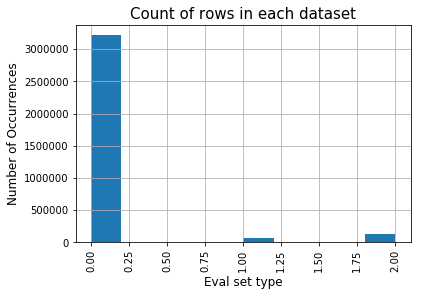

In [8]:
orders_df.eval_set = pd.Categorical(orders_df.eval_set)
orders_df['eval_set_code'] = orders_df.eval_set.cat.codes
orders_df.hist(column='eval_set_code')

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

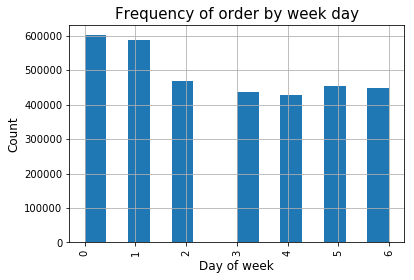

In [9]:
orders_df['order_dow'].hist(bins=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

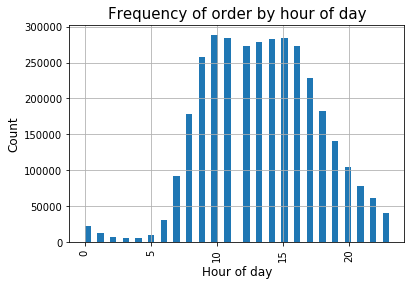

In [10]:
orders_df['order_hour_of_day'].hist(bins=48)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

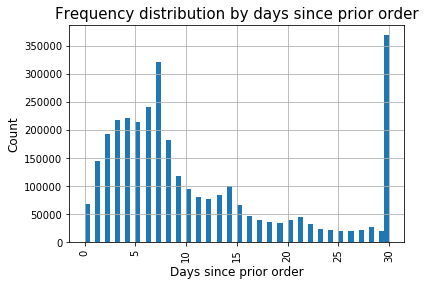

In [11]:
orders_df['days_since_prior_order'].hist(bins=60)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

### Cleaning and formating data

In [87]:
# combine aisles, departments and products (left joined to products)
product_details_df = pd.merge(left=pd.merge(left=products_df, right=departments_df, how='left'), right=aisles_df, how='left')
print(product_details_df.info())

product_details_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49688 entries, 0 to 49687
Data columns (total 6 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
department       49688 non-null object
aisle            49688 non-null object
dtypes: int64(3), object(3)
memory usage: 2.7+ MB
None


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [88]:
from functools import partial

# merge train and prior together iteratively, to fit into 8GB kernel RAM
# split df indexes into parts
indexes = np.linspace(0, len(order_products_prior_df), num=10, dtype=np.int32)


## Begining with train

# Add products_id to orders ie now there is one line per product inside an order
order_details = pd.merge(
                left=order_products_train_df,
                 right=orders_df, 
                 how='left', 
                 on='order_id'
        ).apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

# add information about products (aisles and departments)
order_details = pd.merge(
                left=order_details,
                right=product_details_df[['product_id', 
                             'aisle_id', 
                             'department_id']].apply(partial(pd.to_numeric, 
                                                             errors='ignore', 
                                                             downcast='integer')),
                how='left',
                on='product_id'
)

print(order_details.shape, order_products_train_df.shape)

# delete (redundant now) dataframes
#del order_products_train_df

order_details.head()

(1384617, 12) (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9,120,16
1,1,11109,2,1,112108,train,4,4,10,9,108,16
2,1,10246,3,0,112108,train,4,4,10,9,83,4
3,1,49683,4,0,112108,train,4,4,10,9,83,4
4,1,43633,5,1,112108,train,4,4,10,9,95,15


In [100]:
nb_depts_by_order_df = order_details.groupby('order_id')['department_id'].nunique().to_frame(name='nb_depts')
pd.concat([order_details, nb_depts_by_order_df])

,add_to_cart_order,aisle_id,days_since_prior_order,department_id,eval_set,nb_depts,order_dow,order_hour_of_day,order_id,order_number,product_id,reordered,user_id
0,1.0,120.0,9.0,16.0,train,NaN,4.0,10.0,1.0,4.0,49302.0,1.0,112108.0
1,2.0,108.0,9.0,16.0,train,NaN,4.0,10.0,1.0,4.0,11109.0,1.0,112108.0
2,3.0,83.0,9.0,4.0,train,NaN,4.0,10.0,1.0,4.0,10246.0,0.0,112108.0
3,4.0,83.0,9.0,4.0,train,NaN,4.0,10.0,1.0,4.0,49683.0,0.0,112108.0
4,5.0,95.0,9.0,15.0,train,NaN,4.0,10.0,1.0,4.0,43633.0,1.0,112108.0
5,6.0,24.0,9.0,4.0,train,NaN,4.0,10.0,1.0,4.0,13176.0,0.0,112108.0
6,7.0,24.0,9.0,4.0,train,NaN,4.0,10.0,1.0,4.0,47209.0,0.0,112108.0
7,8.0,21.0,9.0,16.0,train,NaN,4.0,10.0,1.0,4.0,22035.0,1.0,112108.0
8,1.0,2.0,30.0,16.0,train,NaN,6.0,18.0,36.0,23.0,39612.0,0.0,79431.0
9,2.0,115.0,30.0,7.0,train,NaN,6.0,18.0,36.0,23.0,19660.0,1.0,79431.0


In [27]:
order_details.eval_set.value_counts()

train    1384617
Name: eval_set, dtype: int64

In [28]:
%%time
# ADDING PRIOR
# update by small portions
for i in range(len(indexes)-1):
    order_details = pd.concat(
        [   
            order_details,
            pd.merge(left=pd.merge(
                            left=order_products_prior_df.loc[indexes[i]:indexes[i+1], :],
                            right=product_details_df[['product_id', 
                                         'aisle_id', 
                                         'department_id' ]].apply(partial(pd.to_numeric, 
                                                                          errors='ignore', 
                                                                          downcast='integer')),
                            how='left',
                            on='product_id'
                            ),
                     right=orders_df, 
                     how='left', 
                     on='order_id'
                )
        ]
    )
        
print('Datafame length: {}'.format(order_details.shape[0]))
print('Memory consumption: {:.2f} Mb'.format(sum(order_details.memory_usage(index=True, deep=True) / 2**20)))


# delete (redundant now) dataframes
#del order_products_prior_df

Datafame length: 33819114
Memory consumption: 4676.60 Mb
CPU times: user 33 s, sys: 29.8 s, total: 1min 2s
Wall time: 1min 5s


In [29]:
# Get Test data
test_orders = orders_df[orders_df.eval_set == 'test']

#del orders_df

In [30]:
order_details.eval_set.value_counts()

prior    32434497
train     1384617
Name: eval_set, dtype: int64

In [31]:
test_orders.eval_set.value_counts()

test    75000
Name: eval_set, dtype: int64

## Submissions

### Dumb submission

Try as a first submission to gather all the products purchased by the user and buy all them in the next order

In [37]:
%%time
# dumb submission: get the user and give to submission all products buy by the user
test_history = order_details[(order_details.user_id.isin(test_orders.user_id))]\
.groupby('user_id')['product_id'].apply(lambda x: ' '.join([str(e) for e in set(x)])).reset_index()

test_history.columns = ['user_id', 'products']

test_history.head()

CPU times: user 20.6 s, sys: 1.47 s, total: 22 s
Wall time: 22.2 s


In [40]:
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [39]:
test_history.head()

,user_id,products
0,3,17668 44683 48523 21903 14992 21137 32402 2203...
1,4,21573 42329 17769 35469 37646 1200 19057 26576...
2,6,40992 27521 20323 48679 8424 45007 21903 10644...
3,11,17794 8197 30855 33037 30480 10644 26209 35738...
4,12,11520 45056 17794 44422 17159 44683 37646 1499...


In [41]:
%%time


test_history = pd.merge(left=test_history, 
                        right=test_orders, 
                        how='right', 
                        on='user_id')[['order_id', 'products']]
test_history.to_csv('dumb_submission.csv', encoding='utf-8', index=False)



CPU times: user 758 ms, sys: 134 ms, total: 892 ms
Wall time: 911 ms


In [42]:
test_history.head()

,order_id,products
0,2774568,17668 44683 48523 21903 14992 21137 32402 2203...
1,329954,21573 42329 17769 35469 37646 1200 19057 26576...
2,1528013,40992 27521 20323 48679 8424 45007 21903 10644...
3,1376945,17794 8197 30855 33037 30480 10644 26209 35738...
4,1356845,11520 45056 17794 44422 17159 44683 37646 1499...


#### Results

0.2164845

### Last order

Use the last order of the user as a submission

In [44]:
%%time
test_history = order_details[(order_details.user_id.isin(test_orders.user_id))]
last_orders = test_history.groupby('user_id')['order_number'].max()

def get_last_orders(last_orders, test_history):
    t = pd.merge(
            lbneft=pd.merge(
                    left=last_orders.reset_index(),
                    right=test_history,
                    how='inner',
                    on=['user_id', 'order_number']
                )[['user_id', 'product_id']],
            right=test_orders[['user_id', 'order_id']],
            how='left',
            on='user_id'
        ).groupby('order_id')['product_id'].apply(lambda x: ' '.join([str(e) for e in set(x)])).reset_index()
    t.columns = ['order_id', 'products']
    return t

# save submission
get_last_orders(last_orders, test_history).to_csv('last_order.csv', encoding='utf-8', index=False)

CPU times: user 14 s, sys: 2.71 s, total: 16.7 s
Wall time: 17.8 s


#### Result

0.3118026

## Tests in progress

In [ ]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()